<a href="https://colab.research.google.com/github/Nvillaluenga/Neural-Translation-with-attention/blob/NachDev/Neural_Translation_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import unicodedata
import re
import os
import time
import io

print(tf.__version__) # as TF is v=2.3.0 eager execution is enabled by default

2.3.0


In [ ]:
# Get our data
path_to_zip = tf.keras.utils.get_file(
    fname='spa-eng.zip',
    origin='http://download.tensorflow.org/data/spa-eng.zip',
    extract=True)
print(path_to_zip)

path_to_file = os.path.dirname(path_to_zip)+'/spa-eng/spa.txt'
print(path_to_file)

2646016/2638744 [==============================] - 0s 0us/step
/root/.keras/datasets/spa-eng.zip
/root/.keras/datasets/spa-eng/spa.txt


In [ ]:
# Preprocessing functions

def unicode_to_ascii(string):
  return ''.join( c for c in unicodedata.normalize('NFD', string)
    if unicodedata.category(c) != 'Mn' )
  
def preprocess_sentence(string):
  string = unicode_to_ascii(string.lower().strip())
  # separate words from simbols (?.!,¿), eliminate double (or more) spaces
  # and replace every weird stuff non english character with space
  string = re.sub(r'([?.!,¿])', r' \1', string)
  string = re.sub(r'[" "]+', ' ', string)
  string = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', string)
  string = string.rstrip().strip()
  # adding a start and an end token to the sentence
  string = '<start> ' + string + ' <end>'
  return string

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [ [ preprocess_sentence(word) for word in line.split('\t') ]
                for line in lines[:num_examples] ]
  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Testing the functions
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer = load_dataset(path_to_file)
print('## Tensors with indexed text')
print(input_tensor[-1])
print(target_tensor[-1])
print('## Dictonaries from index 2 word and viceversa')
print(inp_lang_tokenizer.index_word)
print(inp_lang_tokenizer.word_index)

<start> may i borrow this book ? <end>
b'<start> \xc2\xbfpuedo tomar prestado este libro ? <end>'
<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
## Tensors with indexed text
[    1    42   174  1476    41    14  1928  1444    17   312   111  1619
     7  4367   933    10   449  1404    20    32   179    70     5    10
   449   496    12     4    14  2041     5  8976  4066     6   161 25355
    20    32   179    70   138     4    19  3896   627  3995    32    12
     6    56  2158     3     2]
[   

In [ ]:
#Limit the size of the dataset to experiment faster (optional)
num_examples = 320000 # Change this number and max values may change
input_tensor, target_tensor, inp_lang, tar_lang = load_dataset(path_to_file,
                                                               num_examples=num_examples)
max_length_tar, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print('Max target length: ' + str(max_length_tar))
print('Max input length: ' + str(max_length_inp))

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train),
      len(input_tensor_val), len(target_tensor_val))

Max target length: 51
Max input length: 53
95171 95171 23793 23793


In [ ]:
# Create a tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(tar_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).shuffle(BUFFER_SIZE)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
  

(TensorShape([64, 53]), TensorShape([64, 51]))

##WRITE ENCODER DECODER MODEL

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

In [ ]:
# Encoder model

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')   
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
    
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))
 


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Encoder output shape: (batch size, sequence length, units) (64, 53, 1024)


In [ ]:
# Bahdanau Attention layer

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = BahdanauAttention(10) # What does this 10 means ?????
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 53, 1)


In [ ]:
# Decoder

class Decoder(tf.keras.Model):
  def __init__ (self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.dec_units = dec_units
    self.batch_sz = batch_sz
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call (self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden,
                                      sample_output)
print (f'Vocab size = {vocab_tar_size}')
print (f'Batch size = {BATCH_SIZE}')
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Vocab size = 12941
Batch size = 64
Decoder output shape: (batch_size, vocab size) (64, 12941)


In [ ]:
# Optimizer, checkpoints and loss function
optimizer = tf.keras.optimizers.Adam()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimize = optimizer,
                                 encoder = encoder,
                                 decoder = decoder)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True,
                                                            reduction = 'none')

def loss_function(real, prediction):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, prediction)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# Training with teacher forcing

@tf.function
def train_step (inp, targ, enc_hidden):
  loss = 0
  
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tar_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]): # For each batch
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)

      # Using teacher forcing - Instead of passing the predictions, we pass correct results
      dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
  
  return batch_loss

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
      

  if (epoch+1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss: {(total_loss / steps_per_epoch):.4f}')
  print(f'Time taken for 1 epoch {time.time()-start}')

Epoch 1 Batch 0 Loss 1.5983
Epoch 1 Batch 100 Loss 0.8615
Epoch 1 Batch 200 Loss 0.8558
Epoch 1 Batch 300 Loss 0.7874
Epoch 1 Batch 400 Loss 0.6986
Epoch 1 Batch 500 Loss 0.7463
Epoch 1 Batch 600 Loss 0.6212
Epoch 1 Batch 700 Loss 0.6904
Epoch 1 Batch 800 Loss 0.5990
Epoch 1 Batch 900 Loss 0.6343
Epoch 1 Batch 1000 Loss 0.5879
Epoch 1 Batch 1100 Loss 0.6536
Epoch 1 Batch 1200 Loss 0.5262
Epoch 1 Batch 1300 Loss 0.5765
Epoch 1 Batch 1400 Loss 0.5489
Epoch 1 Loss: 0.6579
Time taken for 1 epoch 1026.6012399196625
Epoch 2 Batch 0 Loss 0.4808
Epoch 2 Batch 100 Loss 0.5219
Epoch 2 Batch 200 Loss 0.4800
Epoch 2 Batch 300 Loss 0.5693
Epoch 2 Batch 400 Loss 0.4404
Epoch 2 Batch 500 Loss 0.4692
Epoch 2 Batch 600 Loss 0.4955
Epoch 2 Batch 700 Loss 0.4747
Epoch 2 Batch 800 Loss 0.4290
Epoch 2 Batch 900 Loss 0.4141
Epoch 2 Batch 1000 Loss 0.4046
Epoch 2 Batch 1100 Loss 0.3505
Epoch 2 Batch 1200 Loss 0.3459
Epoch 2 Batch 1300 Loss 0.3358
Epoch 2 Batch 1400 Loss 0.3247
Epoch 2 Loss: 0.4107
Time taken

In [ ]:
# Evaluate
def evaluate(sentence):
  attention_plot = np.zeros((max_length_tar, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen = max_length_inp,
                                                         padding = 'post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([tar_lang.word_index['<start>']], 0)

  for t in range(max_length_tar):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tar_lang.index_word[predicted_id] + ' '

    if (tar_lang.index_word[predicted_id] == '<end>'):
      return result, sentence, attention_plot
    
    dec_input = tf.expand_dims([predicted_id], 0)
  
  return result, sentence, attention_plot

In [ ]:
# Translate and plot attention
def plot_attention(attention, input_sentence, predicted_sentence):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap = 'viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + input_sentence, fontdict = fontdict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  plt.show()
  
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print(f'Input: "{sentence}"')
  print(f'Output: "{result}"')

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))



Input: "<start> hace mucho frio aqui . <end>"
Output: "it s been cold here . <end> "


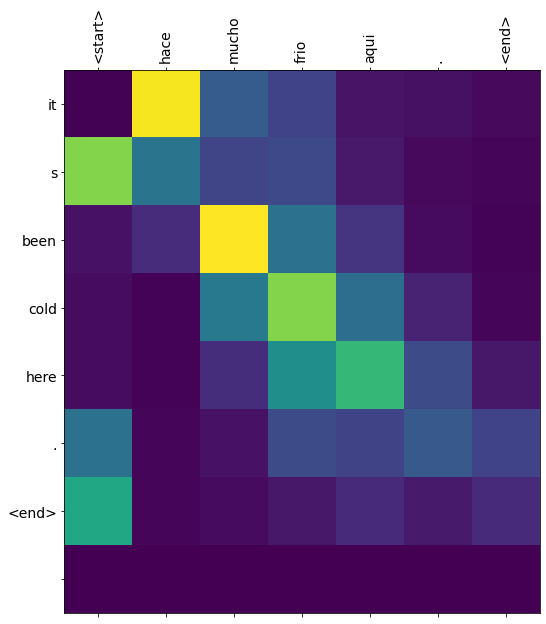

Input: "<start> esta es mi vida ? <end>"
Output: "this is my life ? <end> "


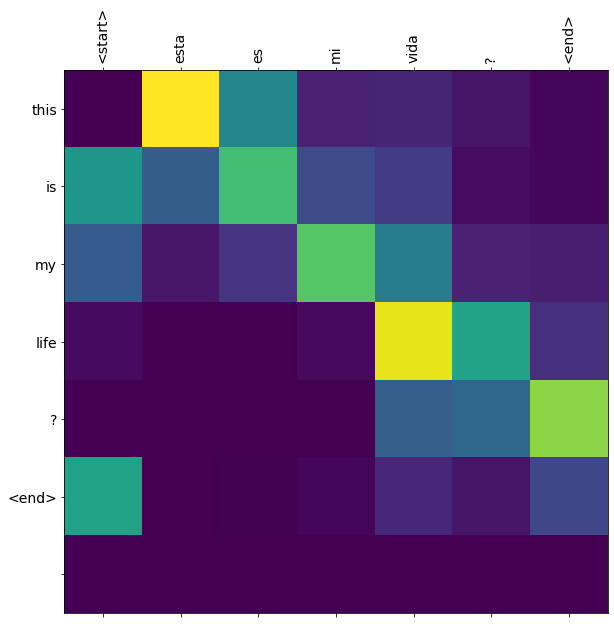

Input: "<start> esta es mi vida <end>"
Output: "this is my life . <end> "


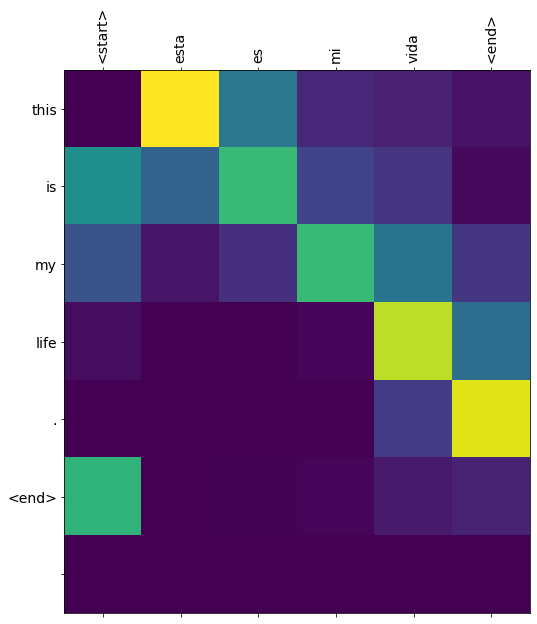

Input: "<start> estas en casa ? <end>"
Output: "you re at home ? <end> "


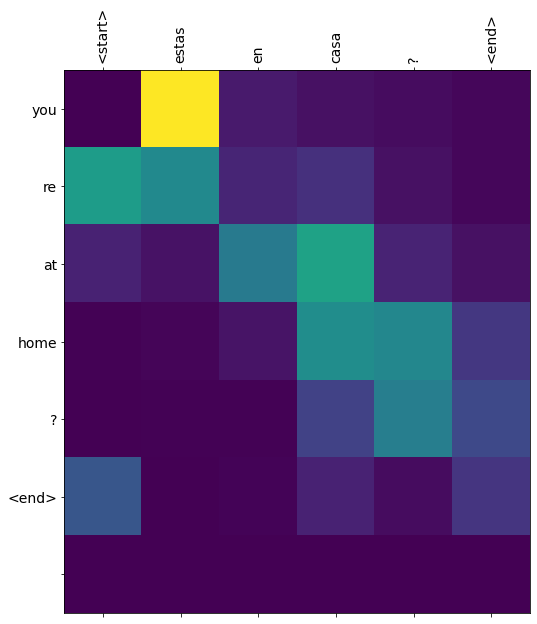

Input: "<start> me gusta mucho la cerveza . <end>"
Output: "i like the beer . <end> "


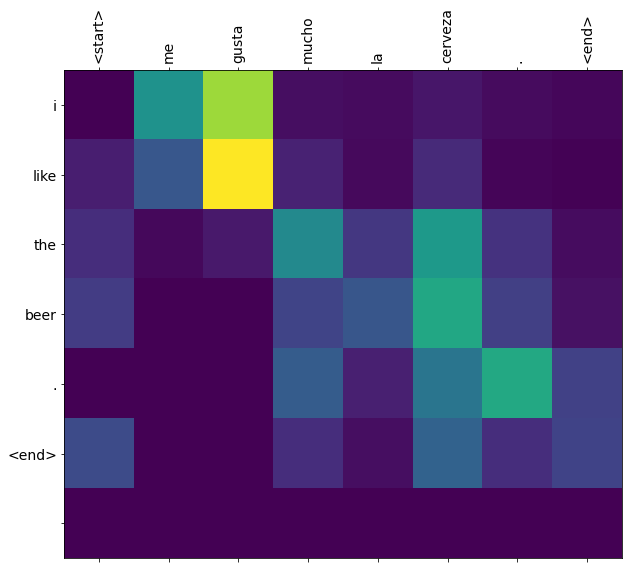

In [26]:
# Restore ckp and try it.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

translate(u'hace mucho frio aqui.')
translate(u'esta es mi vida?')
translate(u'esta es mi vida')
translate(u'estas en casa?')
translate(u'me gusta mucho la cerveza.')